In [1]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import glob
import pandas as pd
from scipy.io import arff
import logging
import os
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from tools.clustering.fuzzy_cmeans import FuzzyCMeansParamsGrid
from tools.clustering import PARAMS_GRID_MAP
from tools.config import DATA_DIR, CLUSTERED_DATA_DIR
from tools.analysis.plots import plot_interactions_with_gridspec

plt.style.use('default')

# Set up logger
logger = logging.getLogger(__name__)

In [2]:
CLUSTERED_DATA_DIR
model_name = 'fuzzy_cmeans'
dataset_name = 'vowel'

In [3]:
SCRIPT_DIR = pathlib.Path(os.getcwd()).absolute()
DATA_DIR = os.path.join(SCRIPT_DIR.parent, "data")
PREPROCESSED_DATA_DIR = f'{DATA_DIR}/1_preprocessed/'

In [4]:
data_path = f"{DATA_DIR}/1_preprocessed/synthetic.csv"
df  = pd.read_csv(data_path)
df['class'].unique()


array([1, 2, 4, 3, 0])

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

METRICS_FILE_PATH = f"{DATA_DIR}/3_metrics.csv"
data = pd.read_csv(METRICS_FILE_PATH)

# Ensure numerical columns are properly parsed (if needed)
# data['runtime'] = pd.to_numeric(data['runtime'], errors='coerce')
# data['ari'] = pd.to_numeric(data['ari'], errors='coerce')
# data['purity'] = pd.to_numeric(data['purity'], errors='coerce')
# data['dbi'] = pd.to_numeric(data['dbi'], errors='coerce')
# data['f_measure'] = pd.to_numeric(data['f_measure'], errors='coerce')

data[data['dataset'] == 'mushroom'][data['model'] == 'fuzzy_cmeans'][data['n_clusters'] == 2]

/var/folders/0m/k4sjt9f13nq8h9cxt8052ykh0000gn/T/ipykernel_2325/1118703523.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['dataset'] == 'mushroom'][data['model'] == 'fuzzy_cmeans'][data['n_clusters'] == 2]
/var/folders/0m/k4sjt9f13nq8h9cxt8052ykh0000gn/T/ipykernel_2325/1118703523.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['dataset'] == 'mushroom'][data['model'] == 'fuzzy_cmeans'][data['n_clusters'] == 2]


,dataset,model,runtime,dbi,chi,ari,f_measure,n_clusters,fuzzyness,max_iterations,...,max_depth,metric,algorithm,min_samples,xi,min_cluster_size,n_neighbors,affinity,eigen_solver,assign_labels
925,mushroom,fuzzy_cmeans,0.132461,2.808719,984.595671,0.600548,0.887184,2.0,1.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
926,mushroom,fuzzy_cmeans,0.199084,2.810931,984.293029,0.605136,0.888682,2.0,2.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
927,mushroom,fuzzy_cmeans,0.119384,3.478447,666.685647,0.013959,0.559084,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
928,mushroom,fuzzy_cmeans,0.149267,1.854090,1295.423663,0.212442,0.702997,2.0,3.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
929,mushroom,fuzzy_cmeans,0.098206,1.854090,1295.423663,0.212442,0.702997,2.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
930,mushroom,fuzzy_cmeans,0.196777,2.683925,1072.226462,0.748343,0.931844,2.0,4.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
931,mushroom,fuzzy_cmeans,0.171795,1.857471,1294.417394,0.213353,0.703638,2.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
932,mushroom,fuzzy_cmeans,0.135145,1.862484,1292.859287,0.214724,0.704599,2.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
model_name = 'optics'

In [7]:
models = data['model'].unique()
datasets = data['dataset'].unique()

In [8]:
# data_for_method = data[data['model'] == model_name] 
params_for_method = list(PARAMS_GRID_MAP[model_name].keys())
datasets, params_for_method

(array(['hepatitis', 'mushroom', 'vowel'], dtype=object),
 ['metric', 'algorithm', 'min_samples', 'xi', 'min_cluster_size'])

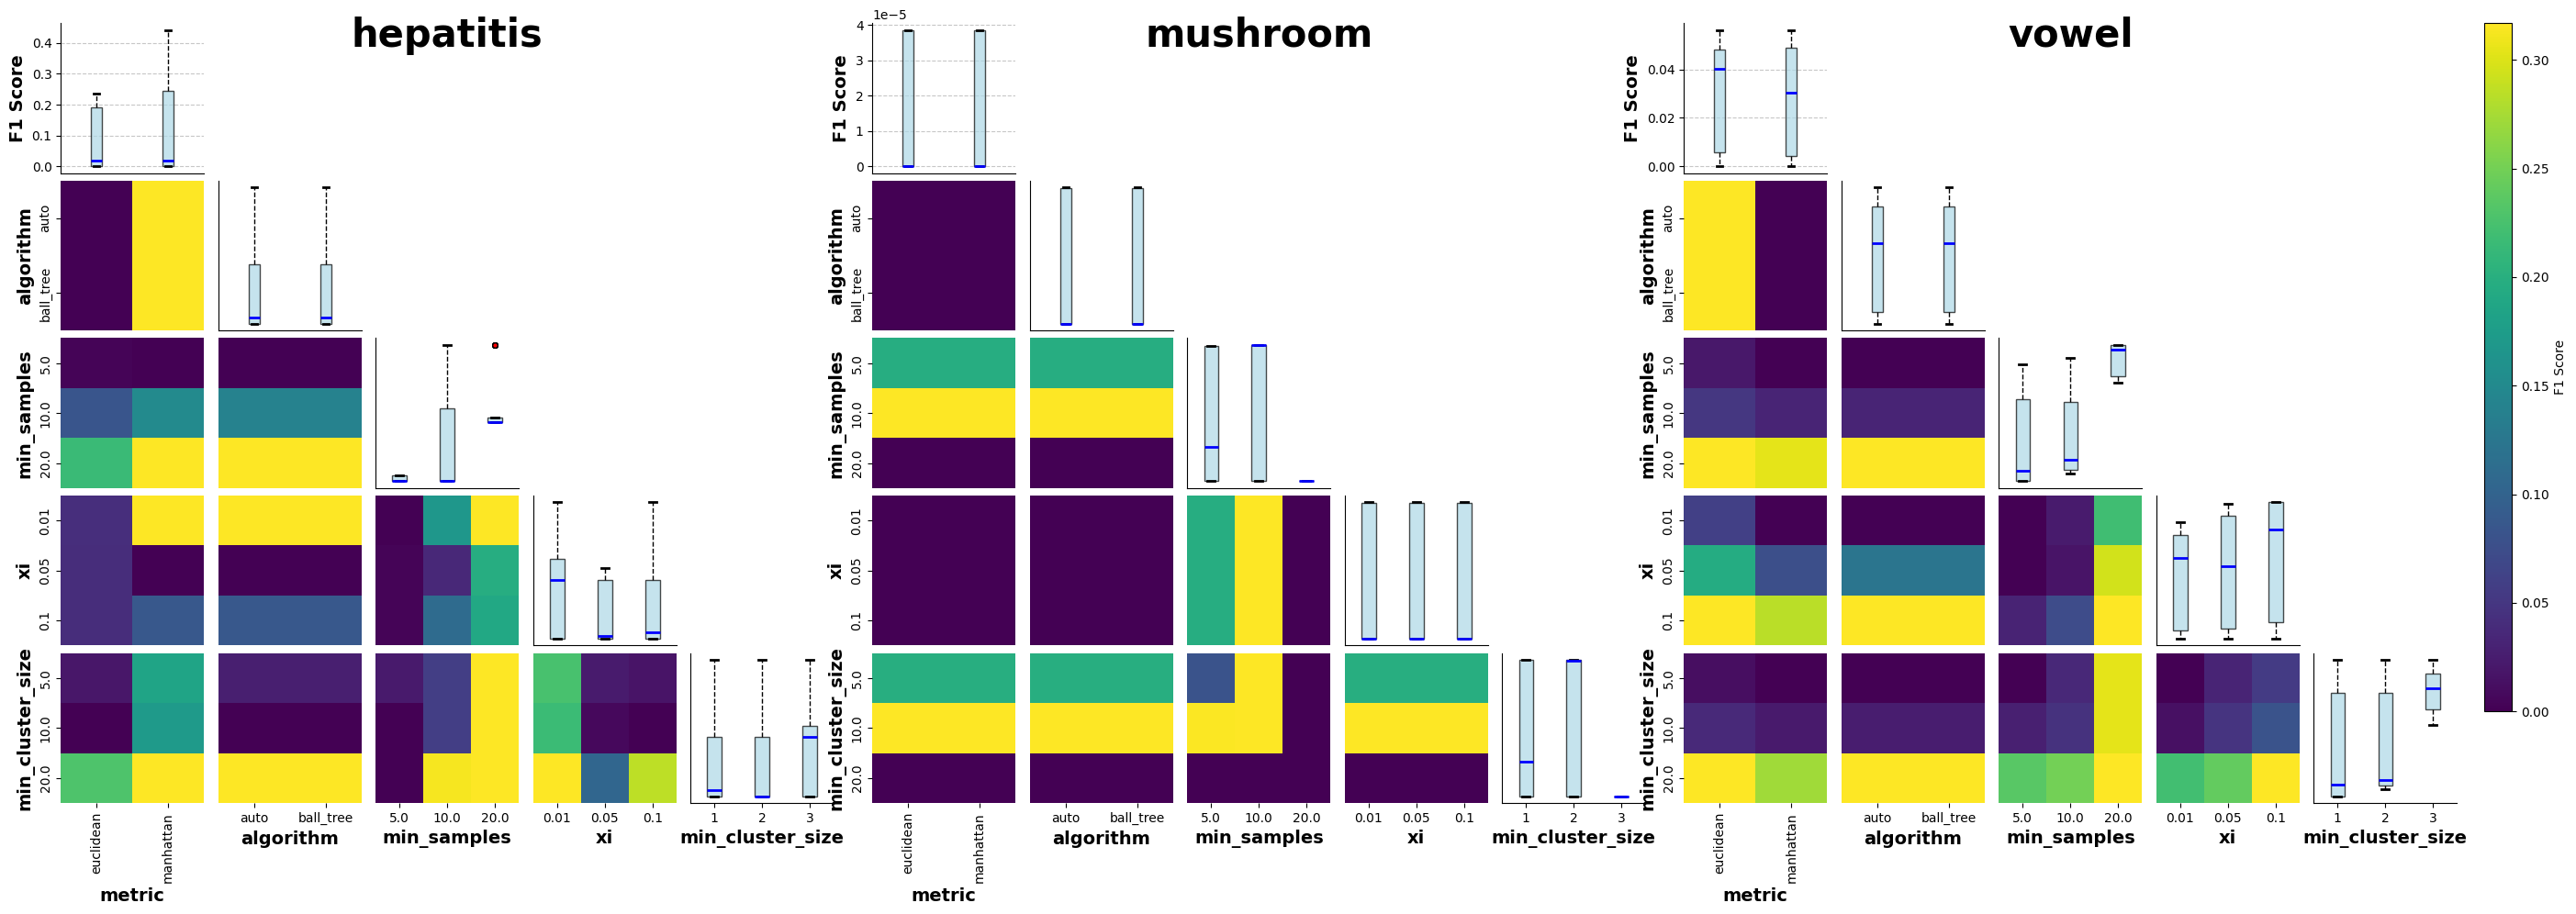

In [9]:
fig = plot_interactions_with_gridspec(
    data,
    params_for_method,
    datasets,
    model_name
)
# fig.suptitle('Interaction Effects of Fu Model Parameters on F1 Score', fontsize=20, fontweight='bold')
# fig.subplots_adjust(top=0.95)
# fig.savefig('../reports/figures/interaction_effects_KNN.png', dpi=300)
plt.show()